## Assignment 6: Classification

#### Introduction

**Goal:** to predict the glass formation in the quaternary space of Co-Ti-Cr-Zr system. The trainin set contains only partial data from three ternary systems, with a good balance of data that is labeled as glass and non-glass. 

**Approach:** Matminer featurizers were used to create over 50 features, after correlation anaysis the number dropped to 9. Using this 9 features and LDA analysis yielded resonably good prediction in LOCO cv (AUC for each being 0.92, 0.84, 0.46). The LDA trained on full dataset then predicted the glass formability of the entire quaternary system, which appear to be a convincing extension of the training dataset.


Notes for myself:

_QUESTION (already addressed)_ How to do feature selection? Should I aim to drop the minimal number of features that makes correlation fall below threshold (e.g. 0.85)? But, a feature that correlates to many other features could also mean it is the most descriptive feature?

In [1]:
import numpy as np
import numpy.matlib as nm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import seaborn as sb

0. Open data, performe basic preparations

In [2]:
### same code as in Assignment 5
sheets = ['CrTiZr', 'CrCoZr', 'CoTiZr']
missing = ['Co', 'Ti', 'Cr']

# make a new dataframe called tert_label
train_df = pd.DataFrame(columns = ['tert_label'])
# create an empty dataframe with column names ['Co', 'Ti', 'Cr', 'Zr', 'MaxFWHM']
df = pd.DataFrame(columns = ['Co', 'Ti', 'Cr', 'Zr'])
### my own forloop
for i in range(len(sheets)):
    sheet_df = pd.read_excel('Metallic Glass Data.xlsx', sheet_name = sheets[i]).dropna()
    sheet_df[missing[i]] = 0
    df = pd.concat([df, sheet_df], ignore_index = True)


    ### this creates label of different tertiary systems, which will be used in the future steps
    # make a pandas series with the same length as the number of rows in sheet_df,
    # fill it with the value of i
    label = pd.Series(nm.repmat(i, sheet_df.shape[0], 1).flatten())
    # add the series to the tert_label of the train_df dataframe
    train_df = pd.concat([train_df, pd.DataFrame({'tert_label': label})], ignore_index = True)

In [3]:
# change column name of Glass (TRUE/FALSE) to isGlass
df = df.rename(columns = {'Glass (TRUE/FALSE)': 'isGlass'})
# if isGlass == True, change to 1, else 0
df['isGlass'] = df['isGlass'].apply(lambda x: 1 if x == True else 0)

In [4]:
import ternary
def df_plot_ternary(df, z, label, ax, title='', cmap=plt.cm.nipy_spectral):
    '''take a three-column df (3 element compositions),
    the color label (z) and label for the colorbar'''
    # make a variable called component which is a list of the first three columns' names
    components = list(df.columns[:3])

    cmp = df.loc[:,components].to_numpy()
    # multiply by 100 to get at.% composition
    cmp = cmp*100
    points=nm.vstack((cmp[:,0].T,cmp[:,2].T)).T

    # fig, ax = plt.subplots()
    
    scale = 100

    grid = plt.GridSpec(10, 10, wspace=2, hspace=1)
    # ax = plt.subplot(grid[:,:9])
    
    figure, tax = ternary.figure(scale=scale, ax=ax)
    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    tax.gridlines(color="blue", multiple=10)

    # Set Axis labels and Title
    fontsize = 12
    offset = 0.14
    tax.right_corner_label(components[0], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.top_corner_label(components[2], fontsize=fontsize, offset=0.23, fontweight='bold')
    tax.left_corner_label(components[1], fontsize=fontsize, offset=0.2, fontweight='bold')
    tax.left_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.right_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.bottom_axis_label("at.%", fontsize=fontsize, offset=offset)
    tax.ticks(axis='lbr', multiple=10, linewidth=1, offset=0.025, clockwise= True)
    tax.get_axes().axis('off')
    tax.clear_matplotlib_ticks()
    
    
    # Create color map and plot color bar
    cmap = cmap
    
    norm = plt.Normalize(0, z.max())
    
    tax.scatter(points, marker='o', c=cmap(norm(z)), 
                # edgecolors='k', 
                alpha=1, s=10, vmin=z.min(), vmax=z.max())
    
    ax2 = plt.subplot(grid[1:-1,9:])
    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='vertical', label=label)
    cb1.set_label(label=label, size=9)

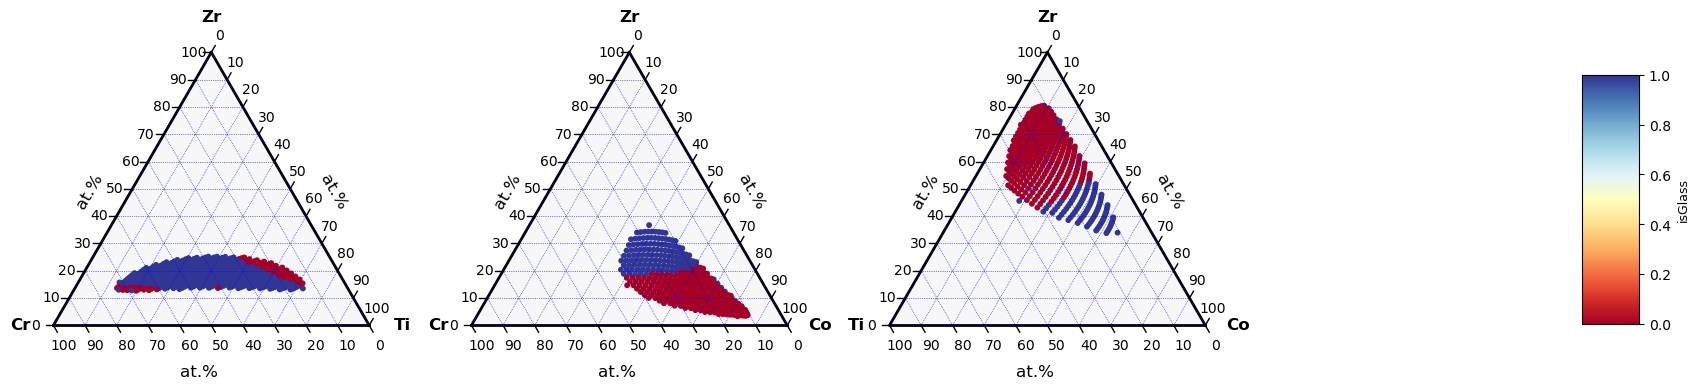

In [5]:
from CustomFunctions import df_plot_ternary
to_drop = ['Co', 'Ti', 'Cr']
fig, axs = plt.subplots(1, 4, figsize = (17, 4))
fig.tight_layout(pad = 2.0)
for i, e in enumerate(to_drop):
    ax = axs[i]
    df_copy = df.copy()
    # in df_copy, drop the rows where e is not 0
    df_copy = df_copy[df_copy[e] == 0]
    # drop the column e
    df_copy = df_copy.drop(e, axis = 1)
    # plot ternary diagram
    df_plot_ternary(df_copy, df_copy.iloc[:, -1], 'isGlass', ax = ax, cmap = plt.cm.RdYlBu)

In [6]:
# ### featurize composition
# dff = df.copy()
# dff.insert(0, 'formula', 
#            'Co' + dff['Co'].astype(str) + 'Ti' + dff['Ti'].astype(str) + 
#            'Cr' + dff['Cr'].astype(str) + 'Zr' + dff['Zr'].astype(str))

# from matminer.featurizers.conversions import StrToComposition
# dff = StrToComposition().featurize_dataframe(dff, 'formula')

# from matminer.featurizers.composition import Miedema, Meredig, WenAlloys, AtomicPackingEfficiency, ElectronegativityDiff

# dff = AtomicPackingEfficiency().featurize_dataframe(dff, col_id='composition')
# dff = Miedema().featurize_dataframe(dff, col_id='composition')
# dff = Meredig().featurize_dataframe(dff, col_id='composition')
# dff = WenAlloys().featurize_dataframe(dff, col_id='composition')
# dff = ElectronegativityDiff().featurize_dataframe(dff, col_id='composition')

# dff.to_excel('dff.xlsx')

In [7]:
### read back the featurized df and do some data cleaning
dff = pd.read_excel('dff.xlsx', index_col=0)

# make a Yang_df with only the Yang delta and Yang omega from dff. We'll use it for plotting
# it is unfortunate that Yang features will be dropped because of its correlation
Yang_df = dff[['Yang delta', 'Yang omega']]

# drop the rows with nan
dff = dff.dropna()

# drop the column if the entire column is 0
dff = dff.loc[:, (dff != 0).any(axis=0)]

In [8]:
features = dff.iloc[:, 7:]

# drop column in features dataframe, if it has non-numeric values
features = features.drop(features.columns[features.dtypes == 'object'], axis=1)

In [9]:

def ranked_drop(features, threshold = 0.85, plot = False):
    '''rank the features based on how often they are correlated with other features. 
    The most correlated ones will be dropped first

    Input:
    features: a dataframe of only numerical features
    threshold: above which features will be considered strongly correlated
    plot: if True, plot the correlation matrix
    
    Output:
    reduced dataframe with only features below the threshold'''
    # make a correlation matrix for features
    corr = features.corr().abs()

    # below fill diagonal code from 
    # https://stackoverflow.com/questions/24475094/set-values-on-the-diagonal-of-pandas-dataframe
    corr.values[[np.arange(corr.shape[0])]*2] = 0

    # create a note_taker dataframe with the same columns as the features dataframe
    note_taker = pd.DataFrame(columns = features.columns) # NOTE: this is to record the features that correlates the most with others

    # for each column in the corr dataframe, count the number of times the correlation is greater than the threshold
    # and then, write the count to the note_taker dataframe
    for col in corr.columns:
        note_taker[col] = [sum(corr[col] > threshold)]

    # rank the columns by the number of times the correlation is greater than the threshold
    note_taker = note_taker.T.sort_values(by = 0, ascending = False).T

    # for each column in the note_taker dataframe, drop the column and row with the same name in the corr dataframe
    # and check if the max correlation is greater than the threshold
    # if there is, check again with the next column in the note_taker dataframe
    # if there is not, break the loop
    for col in note_taker.columns:
        if corr.max().max() > threshold:
            corr = corr.drop(col, axis = 1)
            corr = corr.drop(col, axis = 0)
        else:
            break
    
    '''optional: plotting'''
    if plot == True:
        print('THRESHOLD: ', threshold)
        # plot the correlation matrix
        plt.figure(figsize = (10, 10))
        sb.heatmap(corr, cmap = 'viridis', annot=True)
        plt.show()

    # keep in features dataframe only the columns that remained in the corr dataframe
    features_new = features[corr.columns]
    
    return features_new


/var/folders/zn/k77176sn251cms9l_n4s7zb80000gn/T/ipykernel_4050/503433706.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  corr.values[[np.arange(corr.shape[0])]*2] = 0


THRESHOLD:  0.9


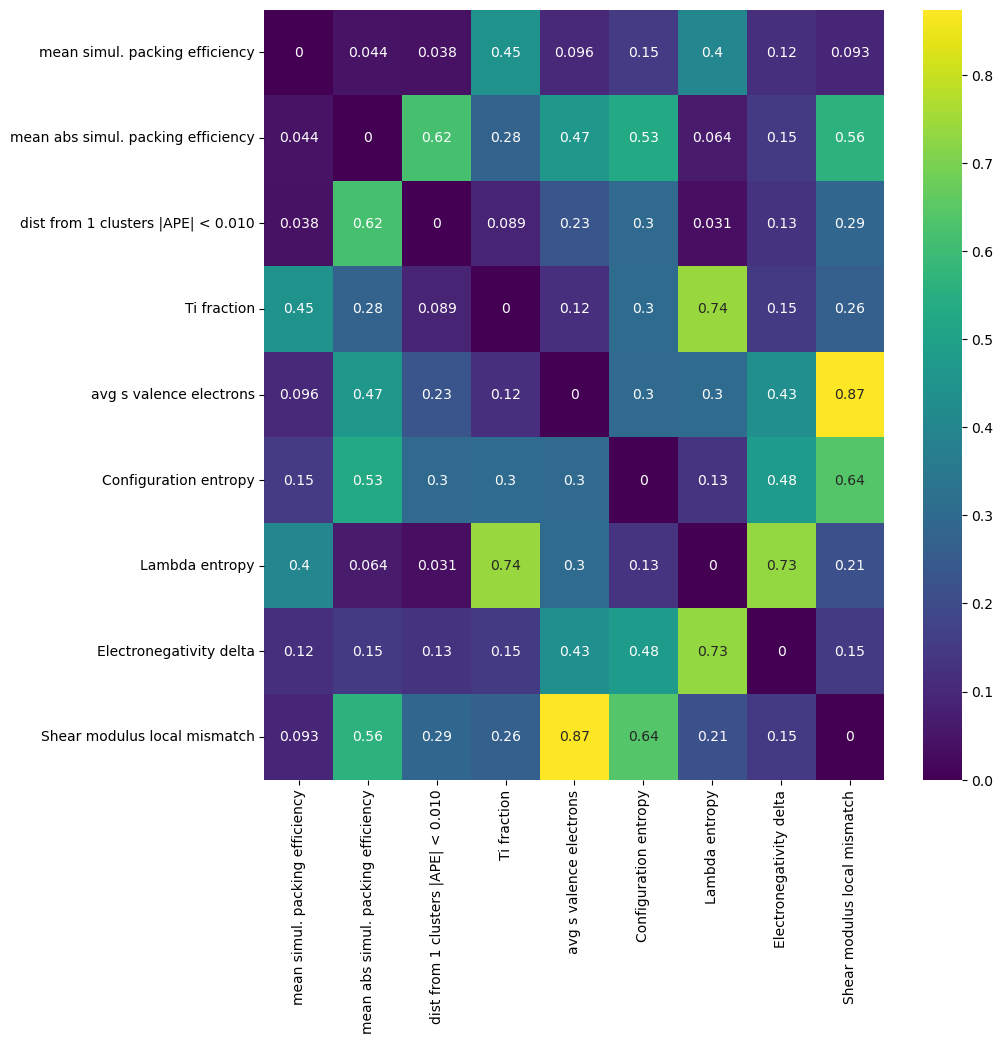

In [10]:
feat_reduced = ranked_drop(features, threshold = 0.9, plot = True)

Define groups for LeaveOneGroupOut:

* split by tertiary systems
* standardize X_test set by X_train

TRAIN: 882 TEST: 441
AUC when leave out Co 0.5073029548361042
TRAIN: 882 TEST: 441
AUC when leave out Ti 0.9469598642172524
TRAIN: 882 TEST: 441
AUC when leave out Cr 0.8365932920473358


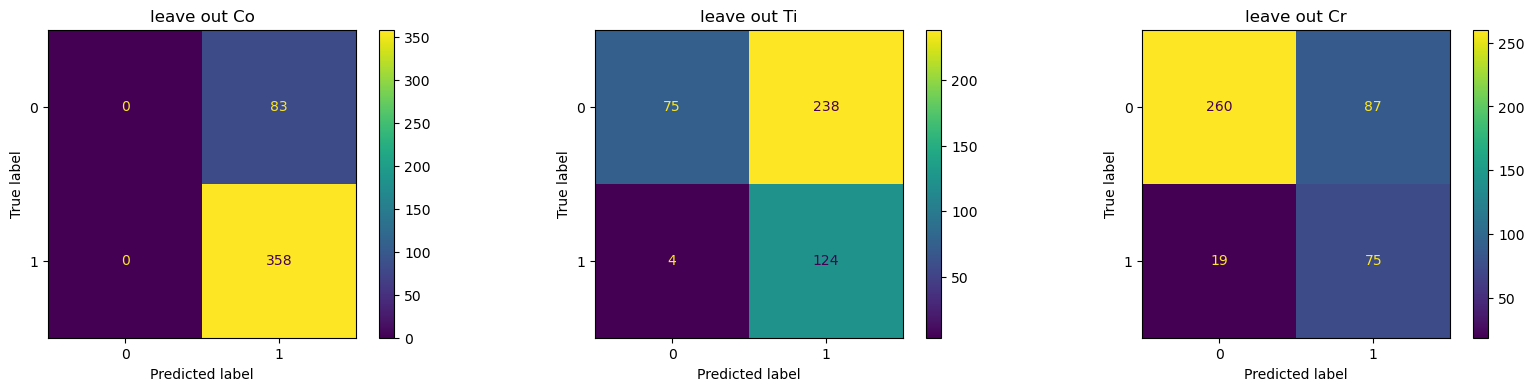

<Figure size 1200x300 with 0 Axes>

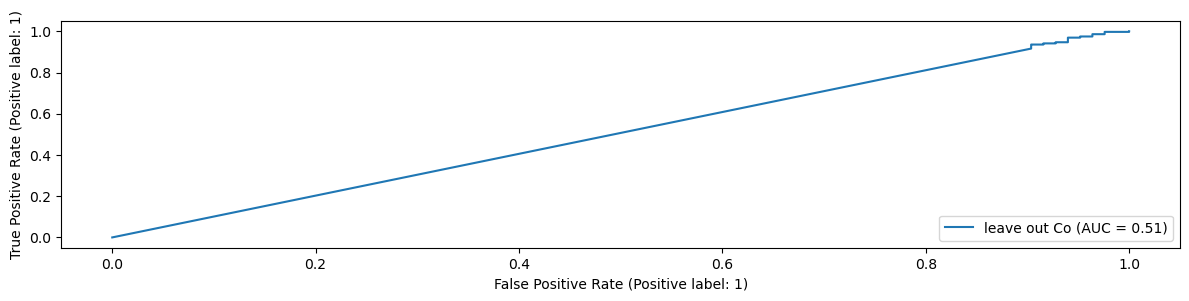

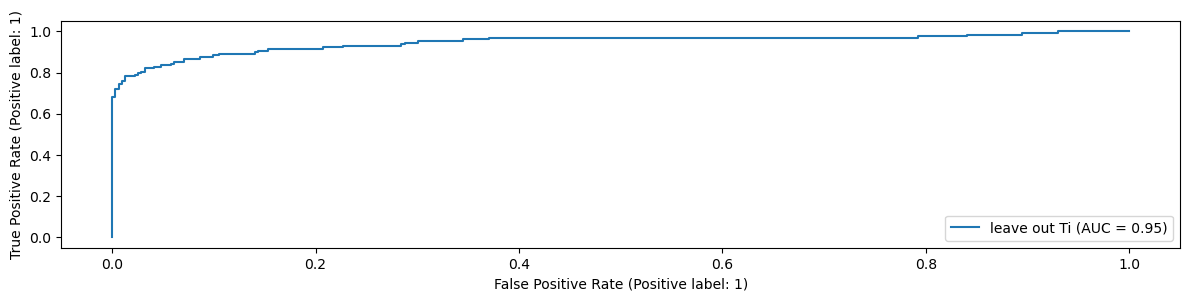

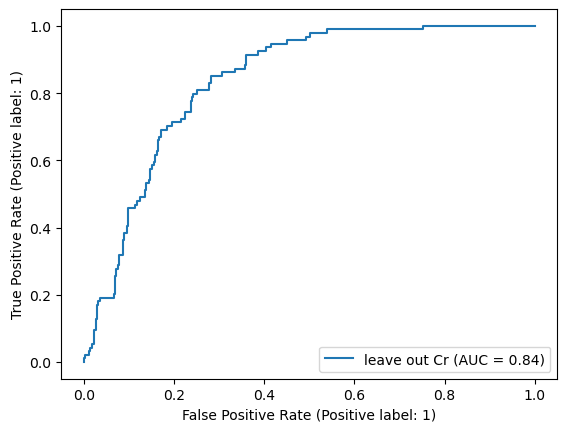

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

terts = train_df['tert_label']

### split data into training and testing
X = feat_reduced.to_numpy()
y = dff['isGlass'].values

LDA = LinearDiscriminantAnalysis()

# below code borrowed from PRA 7
logo = LeaveOneGroupOut()

fig, axs = plt.subplots(1, 3, figsize=(20, 4))

 # those are for confusion matrices
fig2 = plt.figure(figsize = (10, 10))# those are for ROC curves
i = 0
for train_index, test_index in logo.split(X, y, groups = terts): ### ?why use .split() here?
        print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #standarizing the data
        std = StandardScaler().fit(X_train)
        X_train = std.transform(X_train)
        X_test = std.transform(X_test)
#2
        # fit LDA to training set
        LDA.fit(X_train, y_train)

        ConfusionMatrixDisplay.from_estimator(LDA, X_test, y_test, ax=axs[i])
        axs[i].set_title('leave out ' + missing[i])
        # make plot smaller
        plt.gcf().set_size_inches(12, 3)
        plt.tight_layout()

        # Print report AUC
        score = roc_auc_score(y_test, LDA.predict_proba(X_test)[:, 1])
        print('AUC when leave out', missing[i], score)

        # plot ROC curve
        RocCurveDisplay.from_estimator(LDA, X_test, y_test,
                                        # ax=axs2, 
                                       name = 'leave out ' + missing[i])
        fig2.suptitle('ROC of LDA on LOGO groups')

        i += 1


in the first loop, loop through methods (loco vs. random), in the second, loop through ternary systems

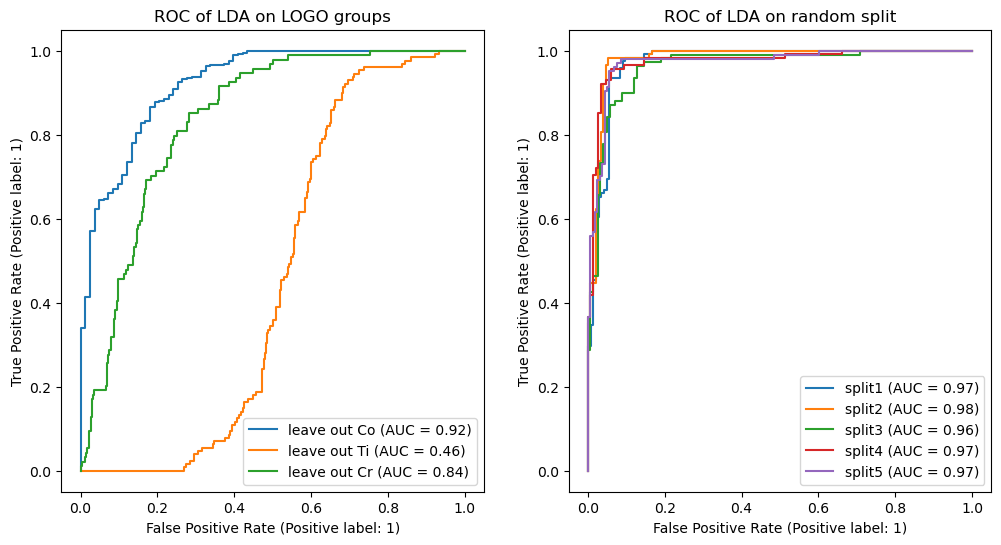

In [13]:
fig, axs = plt.subplots(1, 2)
# set the size of the plot
fig.set_size_inches(12, 6)
# plot the ROC curves for the first group
for i, group in enumerate(logo_results):
    LDA, X_test, y_test = group
    RocCurveDisplay.from_estimator(LDA, X_test, y_test, ax=axs[0], name = 'leave out ' + missing[i])
    axs[0].set_title('ROC of LDA on LOGO groups')

# plot ROC for random splitting
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# below code modified from PRA 7 again
i = 0
for train_index, test_index in ss.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #standarizing the data
        std = StandardScaler()
        std.fit(X_train)
        X_train = std.transform(X_train)
        X_test = std.transform(X_test)

        LDA.fit(X_train, y_train)
        RocCurveDisplay.from_estimator(LDA, X_test, y_test, ax=axs[1], name = 'split' + str(i+1))
        axs[1].set_title('ROC of LDA on random split')

        i +=1


**Interpretation**

this is very interesting to see: in the left plot, the model performs worst in the group where Ti-absent data is left out (i.e. tested on the CrCoZr, trained on the other two which has Ti content). 

This could be caused by that the (only) one composition feature not dropped is: **Ti Fraction**. But this feature has no practical meaning when predicting glass formability on the CrCoZr system. It is not contributing to the predictive power, which weakens the model.

AUC on full data:  0.9699076437555112


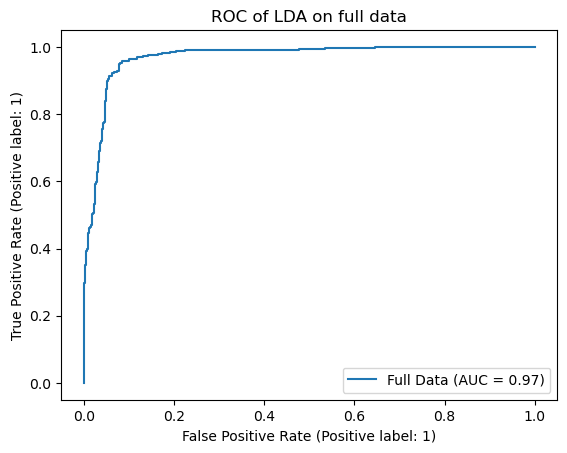

In [14]:
# NEXT, TRAIN ON FULL DATA AND REPORT AUC ON TRAIN DATA
X_train = X
X_train = std.fit_transform(X) # now X_train is both train and test

y_train = y

LDA_full = LinearDiscriminantAnalysis()
LDA_full.fit(X_train, y)
RocCurveDisplay.from_estimator(LDA_full, X_train, y, name = 'Full Data')
# Set title
plt.title('ROC of LDA on full data')

AUC = roc_auc_score(y, LDA_full.predict_proba(X_train)[:, 1])
print('AUC on full data: ', AUC)

In [15]:
# make an empty df2 which has the same column names as df but without the column 'isGlass'
df2 = pd.DataFrame(columns = df.columns[:-1])

for Co in np.arange(0, 1, 0.05):
    for Ti in np.arange(0, 1-Co, 0.05):
        for Cr in np.arange(0, 1-Co-Ti, 0.05):
            row = pd.DataFrame({'Co': Co, 'Ti': Ti, 'Cr': Cr, 'Zr': 1-Co-Ti-Cr}, index=[0])
            df2 = pd.concat([df2, row], ignore_index = True)

#### We've generated the data points in quaternary space (saved into **df2**). Now, let's do some work in the quaternary space.

* featurize df2 with the same features (save into **dff2**)
* drop unreasonable datapoints (which happens when two of the elements are 0, leading to extremely high Yang omega)
* skip the correlation analysis as we just need to keep the same features (as selected in the training data), and then train model on these features

In [16]:
# dff2 = df2.copy()
# dff2.insert(0, 'formula', 
#            'Co' + dff2['Co'].astype(str) + 'Ti' + dff2['Ti'].astype(str) + 
#            'Cr' + dff2['Cr'].astype(str) + 'Zr' + dff2['Zr'].astype(str))

# from matminer.featurizers.conversions import StrToComposition
# dff2 = StrToComposition().featurize_dataframe(dff2, 'formula')

# from matminer.featurizers.composition import Miedema, Meredig, WenAlloys, AtomicPackingEfficiency, ElectronegativityDiff

# dff2 = AtomicPackingEfficiency().featurize_dataframe(dff2, col_id='composition')
# dff2 = Miedema().featurize_dataframe(dff2, col_id='composition')
# dff2 = Meredig().featurize_dataframe(dff2, col_id='composition')
# dff2 = WenAlloys().featurize_dataframe(dff2, col_id='composition')
# dff2 = ElectronegativityDiff().featurize_dataframe(dff2, col_id='composition')

# dff2.to_excel('dff2.xlsx')
### similar to before, some basic data cleaning. 
dff2 = pd.read_excel('dff2.xlsx', index_col=0)

# record the row index of dff2 where Yang omega is greater than 100
index = dff2[dff2['Yang omega'] > 100].index
# drop the rows with Yang omega greater than 100 (in both featureized and unfeatureized df)
dff2 = dff2.drop(index)
df2 = df2.drop(index) # doing this so we can use the same code to plot the ternary diagram

# make a Yang_df with only the Yang delta and Yang omega from dff
Yang_df2 = dff2[['Yang delta', 'Yang omega']]

# drop the rows with nan
dff2 = dff2.dropna()

# drop the column if the entire column is 0
dff2 = dff2.loc[:, (dff2 != 0).any(axis=0)]
feat_reduced2 = dff2.copy()
# in feat_reduced2 keep only the columns in feat_reduced
feat_reduced2 = feat_reduced2.loc[:, feat_reduced.columns]

In [19]:
# predict the glass formation on the entire quaternary diagram (feat_reduced2)
X2 = feat_reduced2.to_numpy()
X2 = std.fit_transform(X2)

isGlass2 = LDA_full.predict(X2)
Glass_proba2 = LDA_full.predict_proba(X2)[:, 1]

(0.2, 9)

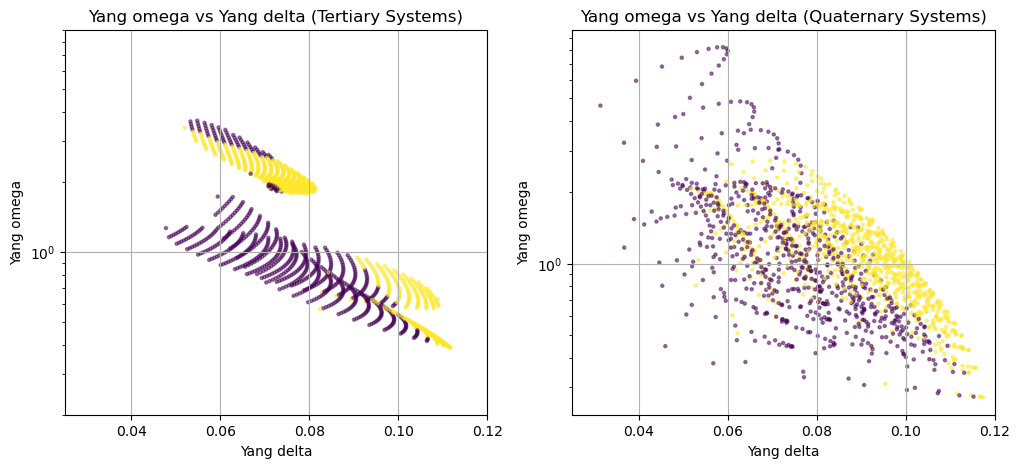

In [20]:
# make a Yang Plot
cmap = 'viridis'
# make two subplots, one row and two columns
fig, axs = plt.subplots(1, 2)

fig.set_size_inches(12, 5)
# set grid on

axs[0].scatter(Yang_df['Yang delta'], Yang_df['Yang omega'], s = 5, 
                      c=dff['isGlass'], alpha = 0.5, cmap=cmap)
axs[0].set_title('Yang omega vs Yang delta (Tertiary Systems)'); axs[0].grid()
axs[0].set_ylabel('Yang omega'); axs[0].set_xlabel('Yang delta'); axs[0].set_yscale('log')
axs[0].set_xlim(0.025, 0.12); axs[0].set_ylim(0.2, 9)

axs[1].scatter(Yang_df2['Yang delta'].values, Yang_df2['Yang omega'].values, s = 5, 
                        c=isGlass2, alpha = 0.5, cmap=cmap)
axs[1].set_title('Yang omega vs Yang delta (Quaternary Systems)'); axs[1].grid()
axs[1].set_ylabel('Yang omega'); axs[1].set_xlabel('Yang delta'); axs[1].set_yscale('log')
axs[1].set_xlim(0.025, 0.12); axs[0].set_ylim(0.2, 9)

In the plot above, the two plots has been adjusted to the same scale. Generally speaking from the plots above, the compositions with large Yang delta and small Yang omega are more likely to be (or be predicted as) glass.

Next, we'll plot probability of glass formation in a ternary phase diagram.

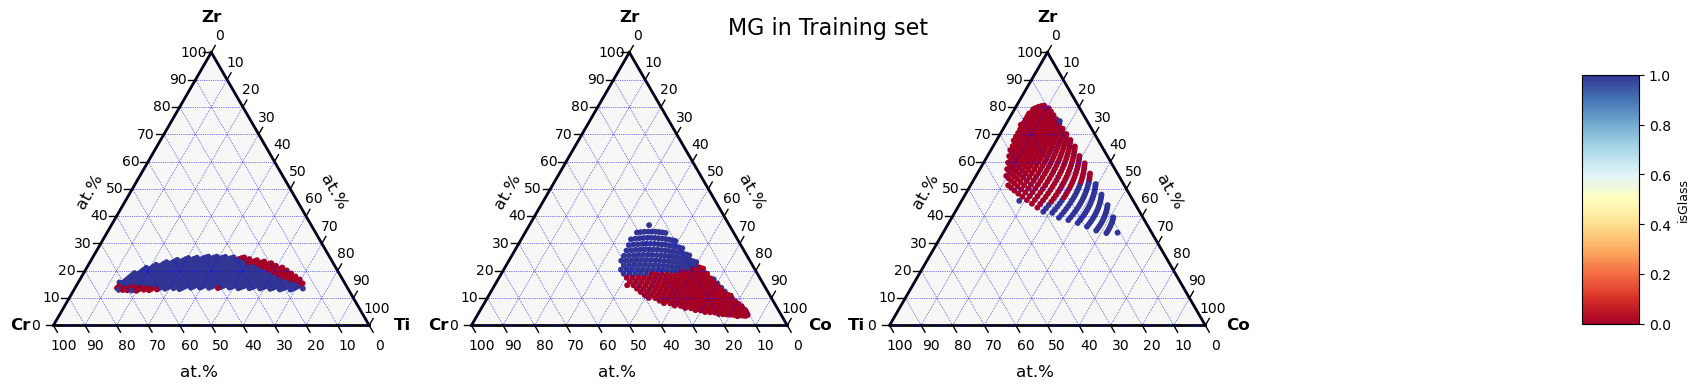

In [21]:
fig, axs = plt.subplots(1, 4, figsize = (17, 4))
fig.tight_layout(pad = 2.0)
# set figure title
fig.suptitle('MG in Training set', fontsize = 16)
for i, e in enumerate(to_drop):
    ax = axs[i]
    df_copy = df.copy()
    # in df_copy, drop the rows where e is not 0
    df_copy = df_copy[df_copy[e] == 0]
    # drop the column e
    df_copy = df_copy.drop(e, axis = 1)
    # plot ternary diagram
    df_plot_ternary(df_copy, df_copy.iloc[:, -1], 'isGlass', ax = ax, cmap = plt.cm.RdYlBu)


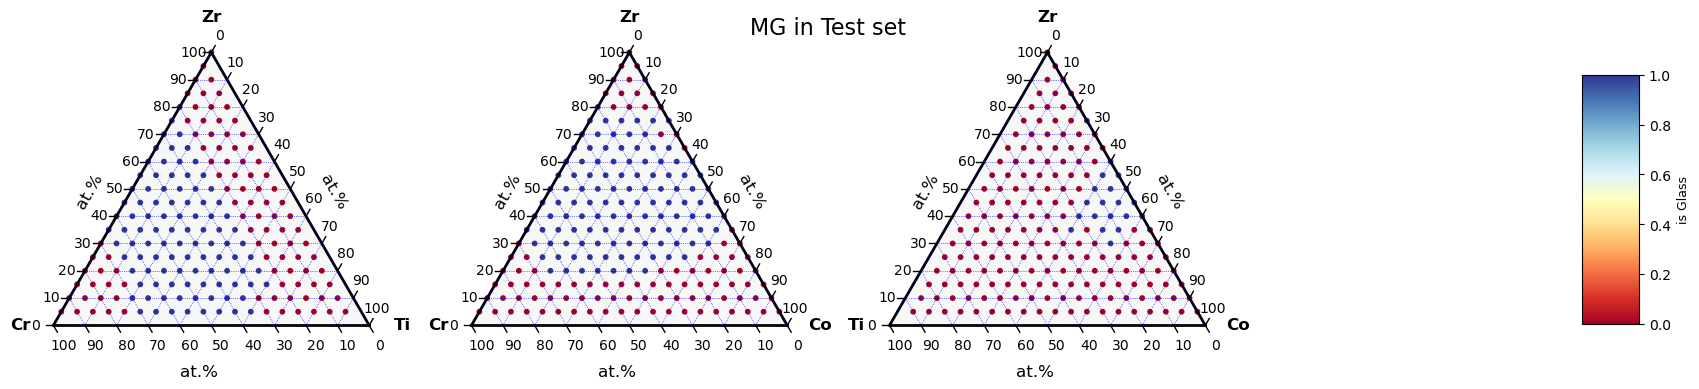

In [22]:
'''NOW LET'S LOOK AT THE CORRESPONDING DIAGRAMS IN QUATERNARY SPACE
NOTE: not plotting them side by side because the plot_ternary function does not like subplots, 
plotting them in the same for-loop messes up the format'''
# add another two column to df2, isGlass and Glass Probability, both are part of the LDA prediction
df2['isGlass'] = isGlass2
df2['Glass_proba'] = Glass_proba2

# plot the predicted probability of glass formation, colored by Glass_proba2
fig, axs = plt.subplots(1, 4, figsize = (17, 4))

fig.tight_layout(pad = 2.0)
# set figure title
fig.suptitle('MG in Test set', fontsize = 16)
for i, e in enumerate(to_drop):
    df2_copy = df2.copy()
    # in df2_copy, drop the rows where e is not 0
    df2_copy = df2_copy[df2_copy[e] == 0]
    # drop the column e
    df2_copy = df2_copy.drop(e, axis = 1)
    # plot ternary diagram
    ax = axs[i]
    df_plot_ternary(df2_copy, df2_copy.iloc[:, -2], 'is Glass', ax = ax, cmap = plt.cm.RdYlBu)



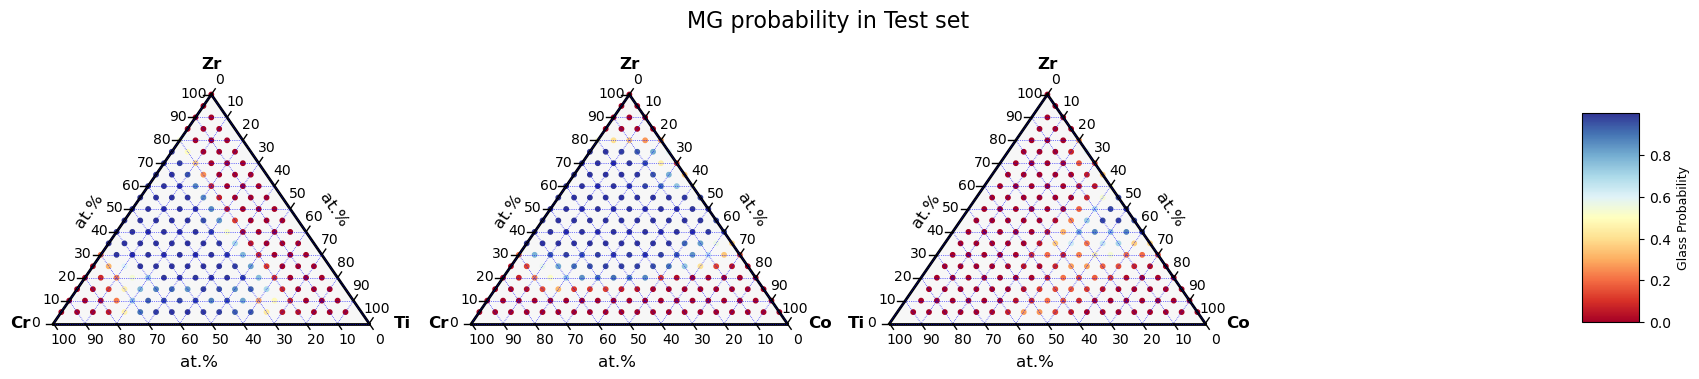

In [23]:
fig2, axs2 = plt.subplots(1, 4, figsize = (17, 4))
fig2.suptitle('MG probability in Test set', fontsize = 16)
fig2.tight_layout(pad = 2.0)

for i, e in enumerate(to_drop):
    df2_copy = df2.copy()
    # in df2_copy, drop the rows where e is not 0
    df2_copy = df2_copy[df2_copy[e] == 0]
    # drop the column e
    df2_copy = df2_copy.drop(e, axis = 1)
    # plot ternary diagram
    ax2 = axs2[i]
    df_plot_ternary(df2_copy, df2_copy.iloc[:, -1], 'Glass Probability', ax = ax2, cmap = plt.cm.RdYlBu)

#### Reflection:

Overall, the model worked out well. 

The predicted glass region not only mapped out quite accurately the glass regions in the training set, it also revealed more glass forming regions that also looks reasonable. The probability plot was also reasonable. 

The only concern is that the cut-off for glass formation is not quite conservative. For example, on all predicted ternary systems, it shows glass-forming region in the binary region (edge of triangle). In other words, the model is not differentiating well between those of very high glass formability and those that are lower. 

Further improvements may be to investigate, using the train set, what features (or linear combination of features) can best separate the glass group from non-glass group, and determine a threashold on that feature. With a threashold, we can tune how conservative we want to make our decision.